In [19]:
# Let's do our usual data science imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import importlib
import os
import subprocess
sns.set(style="darkgrid")

# Define a number of constants
STANDARD_MUTATION = 0.6
STANDARD_MOMENTUM = 1
STANDARD_POPSIZE = 100
STANDARD_SIGMA = 1
PATH_TO_LOG = "storage/logs/"
    
EVALUATION_SCHAFFERS = "SchaffersEvaluation"
EVALUATION_KATSUURA = "KatsuuraEvaluation"
EVALUATION_BCF = "BentCigarFunction"
EVALUATION_SPHERE = "SphereEvaluation"

PARAMETER_POPSIZE = "popsize"
PARAMETER_MOMENTUM = "Momentum"
PARAMETER_MUTATION = "Mutation"
PARAMETER_SIGMA = "Sigma"

In [2]:
# Define the Setup class
class Setup:
    """A setup for a defined parameter and evaluation, with given parameter values.

    Params:
        - param_name (str): Parameter to define
        - evaluation (str): Name of evaluation function to optimise.
        - parameter_values (list): List of values for the associated parameter
    """
    def __init__(self, param_name = "", evaluation = "", parameter_values = []):
        self.param_name = param_name
        self.evaluation = evaluation
        self.parameter_values = parameter_values
        self.parameter_scores = []

In [36]:
# Define the Simulator class
class Simulator:
    """A simulator for a givenn number of setups, and runs to test on each parameter value of a setup.

    Params:
        - setups(list): A list of Setup to test on
        - runs(int): Number of runs per setup
    """
    
    def __init__(self, setups, runs=10):
        self.setups = setups
        self.runs = runs

    def run(self):
        for setup in self.setups:
            self.runEvalsForSetup(setup)

    def constructParams(self, setup, param):
        """Sets up default and preconfigured parameters."""
        mutation = STANDARD_MUTATION
        momentum = STANDARD_MOMENTUM
        sigma = STANDARD_SIGMA
        popsize = STANDARD_POPSIZE

        if setup.param_name == PARAMETER_MUTATION:
            mutation = param

        if setup.param_name == PARAMETER_MOMENTUM:
            momentum = param

        if setup.param_name == PARAMETER_SIGMA:
            sigma = param
        
        if setup.param_name == PARAMETER_POPSIZE:
            popsize = param

        return {
            'mutation': mutation,
            'momentum': momentum,
            'sigma': sigma,
            'popsize': popsize
        }

    def runEvalsForSetup(self, setup):
        """Runs for the current Setup:setup of parameters to test. """
        for param in setup.parameter_values:
            params = self.constructParams(setup, param)
            self.runEval(setup, params, param)

    def runEval(self, setup, params, param):
        """Runs the EA on the igiven eval"""
        scores = 0
        print(scores)
        
        for i in range(self.runs):
            subprocess.run("bash run.sh clean", shell=True)
            subprocess.run("bash run.sh compile", shell=True)
            cmd = "bash run.sh %s %d %f %d" % (setup.evaluation, params['popsize'], params['sigma'], params['momentum'])
            p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
            output = p.stdout.readlines()[0]
            self.storeDataToFiles(output, setup, params, param, i)
            
    def storeDataToFiles(self, output, setup, params, param, run_nr):
        path = PATH_TO_LOG + f"{setup.evaluation}/{setup.param_name}/{setup.param_name}-val-{param}-run-{run_nr}.txt"
        
        if not os.path.exists(os.path.dirname(path)):
            try:
                os.makedirs(os.path.dirname(path))
            except OSError as exc: # Guard against race condition
                if exc.errno != errno.EEXIST:
                    raise

        file = open(path, "w+")
        file.write(str(output.decode()))
        file.close()
    
    def readDataForSetup(self, setup):
        end_df = pd.DataFrame()

        for index, val_metric in enumerate(setup.parameter_values):
            df = pd.DataFrame()
            
            for i in range(self.runs):
                path = PATH_TO_LOG + f"{setup.evaluation}/{setup.param_name}/{setup.param_name}-val-{val_metric}-run-{i}.txt"

                with open(path) as file:
                    output = file.readlines()

                output_reals = eval(output[0])
                df[i] = output_reals

            end_df[index] = df.mean(axis='columns')
            
        return end_df
        

In [37]:
# Initialize a number of setups
katsuura_popsize_setup = Setup(
    PARAMETER_POPSIZE, 
    EVALUATION_KATSUURA,
    np.linspace(50, 500, 50)
)

schaffers_popsize_setup = Setup(
    PARAMETER_POPSIZE, 
    EVALUATION_SCHAFFERS,
    [50, 100]
)

schaffers_momentum_setup = Setup(
    PARAMETER_MOMENTUM,
    EVALUATION_SCHAFFERS,
    np.arange(0, 0.6, 0.1)
)

bcf_popsize_setup = Setup(
    PARAMETER_POPSIZE,
    EVALUATION_BCF,
    [50, 100]
)

setups = [schaffers_momentum_setup]
mainSimulator = Simulator(setups)

In [38]:
mainSimulator.run()

0
0
0
0
0
0


In [44]:
schaffers_popsize_results = mainSimulator.readDataForSetup(setups[0])

schaffers_popsize_results[schaffers_popsize_results][0]

ValueError: Must pass DataFrame with boolean values only

In [42]:
sns.relplot( hue="region", kind="line", data=schaffers_popsize_results)

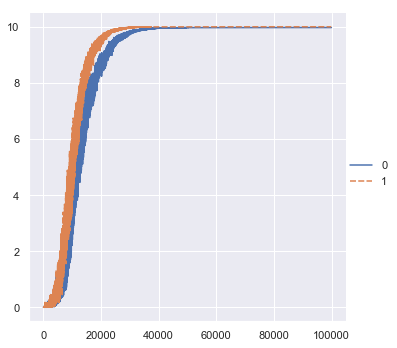

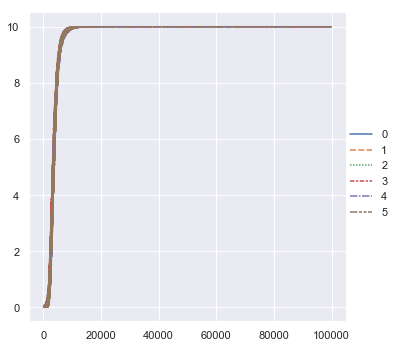

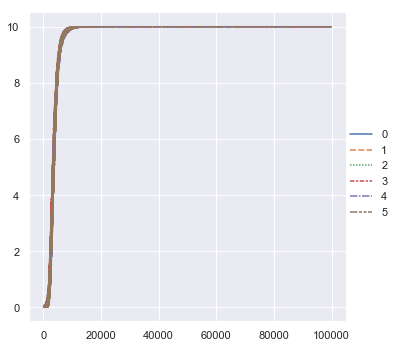

In [43]:
plt.show()